In [1]:
using Distributions, Plots, StatsPlots
using CSV, DataFrames
using QuantileRegressions
using GLM

# Quantile Regression

The $\alpha$ quantile of a random variable $Y$, conditional on $X=x$
(notation: $Y_{\alpha|X=x})$ is the smallest value $z$ such that
$Pr(Y\leq z|X=x)=\alpha$. 

If $F_{Y|X=x}$ is the conditional CDF of $Y,$ then the $\alpha$-conditional
quantile is 
$$
Y_{\alpha|X=x}=\inf y:\alpha\leq F_{Y|X=x}(y).
$$
 


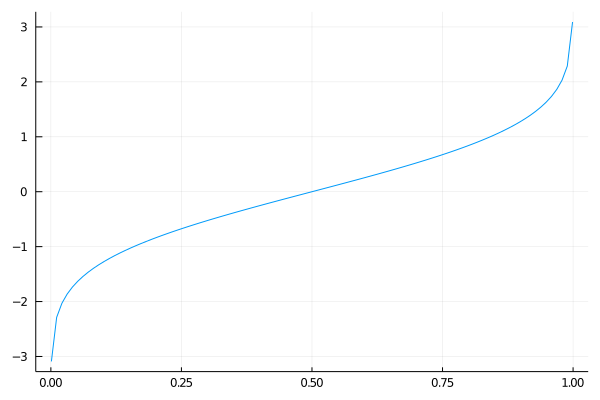

In [2]:
N=100
grid = range(0.001,stop=0.999,length=N)
plot(grid,quantile.(Normal(),grid),legend=false)

When $\alpha=0.5,$ we are talking about the conditional median $Y_{0.5|X=x}$,
but we could be interested in other quantiles, too. 

The linear regression model is focused on the conditional mean of
the dependent variable. 

However, when looking at economic policies, we're often interested in distributional effects:
- we may like to know how the rich and poor may be differentially affected
by a policy that provides a public good
- we might like to know how a training program affects low-performing
students compared to high-performing students 

The classical linear regression model $y_{t}=x_{t}^{\prime}\beta+\epsilon_{t}$
with normal errors implies that the distribution of $y_{t}$ conditional
on $x_{t}$ is
$$
y_{t}\sim N(x_{t}^{\prime}\beta,\sigma^{2})
$$

 Note that $Pr(Y<x^{\prime}\beta|X=x)=0.5$ when the model follows
the classical assumptions with normal errors, because the normal distribution
is symmetric about the mean, so the mean and the median are the same,
that is, $Y_{0.5|X=x}=x^{\prime}\beta$. 


We have $y=x^{\prime}\beta+\epsilon$ and
$\epsilon\sim N(0,\sigma^{2})$. 
- Conditional on $x$, $x^{\prime}\beta$ is given, and the distribution
of $\epsilon$ does not depend on $x$. 
- Note that $\epsilon/\sigma$ is standard normal, and the $\alpha$
quantile of $\epsilon/\sigma$ is simply the inverse of the standard
normal CDF evaulated at $\alpha,$ $\Phi^{-1}(\alpha)$, where $\Phi$
is the standard normal CDF function. 
- The probit function $\Phi^{-1}(\alpha)$ is tabulated (or can be found
in Julia using \texttt{using Distributions; y = quantile.(Normal(),range(0.001,stop=0.999,length=200))}.
It is plotted in Figure \ref{fig:Inverse-CDF-for}. 

The $\alpha$ quantile of $\epsilon$ is $\sigma\Phi^{-1}(\alpha).$
Thus, the $\alpha$ conditional quantile of $y$ is $Y_{\alpha|X=x}=x^{\prime}\beta+$$\sigma$$\Phi^{-1}(\alpha)$.

These give confidence intervals for the the fitted value, $x^{\prime}\beta$. 


## Fully Nonparametric 


To compute conditional quantiles for the classical linear model, we
used the assumption of normality. Can we estimate conditional quantiles
without making distributional assumptions? Yes, we can! (nod to Obama)
(a note from 2018: those were the good old days!). You can do fully
nonparametric conditional density estimation
and use the fitted conditional density to compute quantiles.
- Note that estimating quantiles where $\alpha$ is close to 0 or 1
is difficult, because you have few observations that lie in the neighborhood
of the quantile, so you should expect a large variance if you go the
nonparametric route. For more central quantiles, like the median,
this will be less of a problem.
- For this reason, we may go the \emph{semi-parametric} route, which
imposes more structure. When people talk about quantile regression,
they usually mean the semi-parametric approach.

## Quantile Regression as a Semi-Parametric Estimator

The most widely used method does not take either of the extreme positions,
it is not fully parametric, like the linear regression model with
known distribution of errors, but some parametric restrictions are
made, to improve efficiency compared to the fully nonparametric approach.


The assumption is that the $\alpha$-conditional quantile of the dependent
variable $Y$ is a linear function of the conditioning variables $X$:
$Y_{\alpha|X=x}=x^{\prime}\beta_{\alpha}$. 

This is a generalization of what we get from the classical model with
normality, where the slopes of the quantiles with respect to the regressors
are constant for all $\alpha$: 
- For the classical model with normality, $\frac{\partial}{\partial x}Y_{\alpha|X=x}=\beta$. 
- With the assumption of linear quantiles without distributional assumptions,
$\frac{\partial}{\partial x}Y_{\alpha|X=x}=\beta_{\alpha}$, so the
slopes (and constants) are allowed to change with $\alpha$. 

This is a step in the direction of flexibility, but it also means
we need to estimate many parameters if we're interested in many quantiles:
there may be an efficiency loss due to using many parameters to avoid
distributional assumptions.


The question is how to estimate $\beta_{\alpha}$ when we don't make
distributional assumptions.

It turns out that the problem can be expressed as an extremum estimator:
$\widehat{\beta_{\alpha}}=\arg\min s_{n}(\beta)$ where
$$
s_{n}(\beta)=\sum_{i=1}^{n}\left[1(y_{i}\geq x_{i}^{\prime}\beta_{\alpha})\alpha+1(y_{i}<x_{i}^{\prime}\beta_{\alpha})(1-\alpha)\right]\left|y_{i}-x_{i}^{\prime}\beta_{\alpha}\right|
$$
First, suppose that $\alpha=0.5,$ so we are estimating the median.
Then the objective simplifies to minimizing the absolute deviations:
$$
s_{n}(\beta)=\sum_{i=1}^{n}\left|y_{i}-x_{i}^{\prime}\beta_{\alpha}\right|
$$

The presence of the weights in the general version accounts for the
fact that if we're estimating the $\alpha=0.1$ quantile, we expect
90\% of the $y_{i}$ to be greater than $x_{i}^{\prime}\beta_{\alpha}$,
and only 10\% to be smaller. We need to down-weight the likely events
and up-weight the unlikely events so that the objective function minimizes
at the appropriate place.

## Example

Koenker, Roger and Kevin F. Hallock. "Quantile Regression". Journal of Economic Perspectives, Volume 15, Number 4, Fall 2001, Pages 143–156


We are interested in the relationship between income and expenditures on food for a sample of working class Belgian households in 1857 (the Engel data).

In [3]:
df = DataFrame(CSV.File("../data/engel.csv"))

,Column1,income,foodexp
,Int64,Float64,Float64
1,1,420.158,255.839
2,2,541.412,310.959
3,3,901.157,485.68
4,4,639.08,402.997
5,5,750.876,495.561
6,6,945.799,633.798
7,7,829.398,630.757
8,8,979.165,700.441
9,9,1309.88,830.959


In [4]:
qreg(@formula(foodexp ~ income), df, .5)

StatsModels.TableRegressionModel{QuantileRegressions.QRegModel,Array{Float64,2}}

foodexp ~ 1 + income

Coefficients:
──────────────────────────────────────────────────────
             Quantile   Estimate   Std.Error   t value
──────────────────────────────────────────────────────
(Intercept)       0.5  81.4822    14.6345      5.56783
income            0.5   0.560181   0.0131756  42.5164
──────────────────────────────────────────────────────

In [5]:
QNum = 20
[[i/(QNum) for i in 1:QNum] [i/(QNum+1) for i in 1:QNum]]

20×2 Array{Float64,2}:
 0.05  0.047619
 0.1   0.0952381
 0.15  0.142857
 0.2   0.190476
 0.25  0.238095
 0.3   0.285714
 0.35  0.333333
 0.4   0.380952
 0.45  0.428571
 0.5   0.47619
 0.55  0.52381
 0.6   0.571429
 0.65  0.619048
 0.7   0.666667
 0.75  0.714286
 0.8   0.761905
 0.85  0.809524
 0.9   0.857143
 0.95  0.904762
 1.0   0.952381

In [6]:
coef_inc = [coeftable(qreg(@formula(foodexp ~ income), df, i/(QNum+1), IP())).cols[2][2] for i in 1:QNum];
std_inc = [coeftable(qreg(@formula(foodexp ~ income), df, i/(QNum+1), IP())).cols[3][2] for i in 1:QNum];
QuantilePlot = [coef_inc std_inc]

20×2 Array{Float64,2}:
 0.343361  0.037963
 0.381742  0.0263034
 0.424312  0.0208779
 0.445529  0.0193425
 0.47569   0.0173738
 0.482792  0.0170315
 0.485657  0.0160995
 0.494322  0.0156188
 0.535414  0.0146762
 0.55081   0.0136386
 0.555628  0.0129735
 0.577254  0.0122063
 0.586615  0.0116107
 0.610325  0.0111631
 0.62253   0.0110336
 0.65408   0.0106947
 0.658167  0.0100558
 0.676209  0.0106107
 0.694096  0.0135442
 0.709356  0.0100666

In [7]:
lm(@formula(foodexp ~ income), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

foodexp ~ 1 + income

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  147.475     15.9571      9.24    <1e-16  116.037     178.914
income         0.485178   0.0143664  33.77    <1e-91    0.456874    0.513483
────────────────────────────────────────────────────────────────────────────

In [8]:
coef_inc = [coeftable(lm(@formula(foodexp ~ income), df)).cols[1][2] for i in 1:QNum];
std_inc = [coeftable(lm(@formula(foodexp ~ income), df)).cols[2][2] for i in 1:QNum];
OLSPlot = [coef_inc std_inc]

20×2 Array{Float64,2}:
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664
 0.485178  0.0143664

In [9]:
PlotDF = DataFrame(
    Quantile = range(1, length=QNum, stop=QNum)/(QNum+1),
    Beta = QuantilePlot[:,1],
    OLSPlot = OLSPlot[:,1],
    Beta_min = QuantilePlot[:,1] - 1.96 * QuantilePlot[:,2],
    Beta_max = QuantilePlot[:,1] + 1.96 * QuantilePlot[:,2])

,Quantile,Beta,OLSPlot,Beta_min,Beta_max
,Float64,Float64,Float64,Float64,Float64
1,0.047619,0.343361,0.485178,0.268954,0.417769
2,0.0952381,0.381742,0.485178,0.330187,0.433296
3,0.142857,0.424312,0.485178,0.383391,0.465232
4,0.190476,0.445529,0.485178,0.407618,0.48344
5,0.238095,0.47569,0.485178,0.441637,0.509742
6,0.285714,0.482792,0.485178,0.44941,0.516173
7,0.333333,0.485657,0.485178,0.454102,0.517212
8,0.380952,0.494322,0.485178,0.463709,0.524935
9,0.428571,0.535414,0.485178,0.506649,0.56418


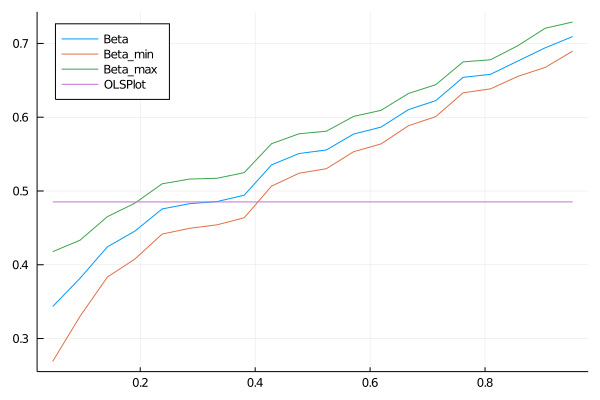

In [10]:
@df PlotDF plot(:Quantile, [:Beta :Beta_min :Beta_max :OLSPlot], legend=:topleft)